# Tumor morphology

This Jupyter notebook reproduces various panels from Figure 1, which explores the morphology of the tumors from our Sleeping Beauty (SB) insertional mutagenesis screen in WapCre;Cdh1F/F;SB mice.

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('white', {
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'text.color': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

## Morphology overview

To provide an overview of the different morphologies for each of the samples, we parse the provided pathology descriptions into three pre-defined categories (ILC, Spindle cell and Squamous) that make up these descriptions. This allows us to determine which morphologies are present in each sample.

In [2]:
from nbsupport import morphology as morph
from nbsupport.util.clustermap import sort_matrix

# Read sample definition.
samples = (pd.read_csv('../data/raw/sb/samples.txt', sep='\t')
             .assign(pathology_type=lambda df: df['pathology_type'].str.lower()))

# Define morphology annotation based on sample definitions.
morphology = morph.parse_morphology(samples)

morphology.head()

,ILC,Spindle cell,Squamous
sample,,,
11KOU018,True,True,True
11KOU031-R5,True,True,True
12SKA017,True,True,True
12SKA029-R5-L5,True,True,True
12SKA038-R5,True,True,True


As we are also interested in visualizing which samples have metastases, we read the provided metastasis overview (which lists the metastasis sites observed in each mouse) and translate this overview from mouse ids to the corresponding samples.

In [3]:
# Read mouse metastases.
metastases = pd.read_csv('../data/raw/sb/metastases.txt', sep='\t')
metastases = metastases.ix[metastases['mouse'].isin(samples['mouse'])]

# Assign metastases to samples.
sample_metastases = (
    samples.get(['mouse', 'sample'])
           .assign(Metastasis=lambda df: df['mouse'].isin(set(metastases['mouse'])))
           .drop('mouse', axis=1)
           .set_index('sample'))

Finally, we use the function **plot_morphology** to visualize the morphologies together with the metastasis data in a 2D heatmap. This function essentially plots each of the binary categories as a colored heatmap (with a separate color for each column) and adds some styling. The resulting heatmap provides a nice overview of the distribution of morphologies, whilst highlighting the fact that many tumors show multiple morphologies.

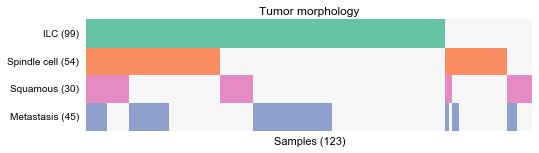

In [4]:
# Plot as heatmap.
fig, ax = plt.subplots(figsize=(8, 2))
morph.plot_morphology(morphology, metastases=sample_metastases, ax=ax)
ax.set_xlabel('Samples ({})'.format(morphology.shape[0]));

# Draw again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(4, 1.5))
    morph.plot_morphology(morphology, metastases=sample_metastases, ax=ax)
    ax.set_xlabel('Samples ({})'.format(morphology.shape[0]))

fig.savefig('../reports/figures/fig_1_morphology.pdf', bbox_inches='tight')
plt.close(fig)

## Metastasis sites

To visualize the general locations of metastases in these mice, we use the provided metastasis overview (which lists metastasis sites for each mouse) to create a 2D matrix of sites-by-mice. This boolean matrix is the plotted as a binary heatmap.

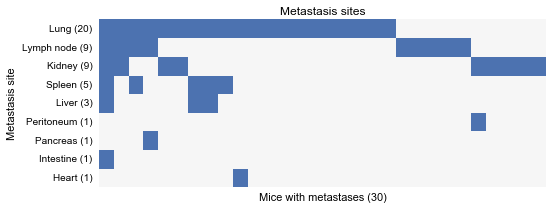

In [5]:
# Pivot to matrix of mice-by-sites.
metastases_mat = pd.pivot_table(
    metastases, index='mouse', columns='metastasis_site',
    aggfunc=len, fill_value=0)

# Plot metastasis matrix.
fig, ax = plt.subplots(figsize=(8, 3))
morph.plot_metastases(metastases_mat, ax=ax)
ax.set_xlabel('Mice with metastases ({})'
              .format(metastases_mat.shape[0]))
ax.set_ylabel('Metastasis site')

# Draw again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(4, 2.2))
    
    morph.plot_metastases(metastases_mat, ax=ax)
    ax.set_xlabel('Mice with metastases ({})'
              .format(metastases_mat.shape[0]))
    ax.set_ylabel('Metastasis site')

    fig.savefig('../reports/figures/fig_1_metastases.pdf', bbox_inches='tight')
    plt.close(fig)